In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pylab as pl

In [2]:
# HIDDEN

columns = ['mar_status', 'gender', 'rel_rating', 'age']
couples = Table.read_table('married_couples.csv').select(columns)

def describe(column, descriptions):
    """Relabel a column of codes and add a column of descriptions"""
    code = column + '_code'
    couples.relabel(column, code)
    couples[column] = np.choose(couples[code]-1, descriptions)
    
describe('mar_status', ['married', 'partner'])
describe('gender', ['male', 'female'])
describe('rel_rating', [
    'very satisfied', 
    'somewhat satisfied', 
    'neither satisfied nor dissatisfied', 
    'somewhat dissatisfied', 
    'very dissatisfied', 
])
couples['count'] = 1
couples['high_rating'] = couples['rel_rating'] == 'very satisfied'
couples

mar_status_code,gender_code,rel_rating_code,age,mar_status,gender,rel_rating,count,high_rating
1,1,1,51,married,male,very satisfied,1,True
1,2,1,53,married,female,very satisfied,1,True
1,1,1,57,married,male,very satisfied,1,True
1,2,1,57,married,female,very satisfied,1,True
1,1,1,60,married,male,very satisfied,1,True
1,2,1,57,married,female,very satisfied,1,True
1,1,1,62,married,male,very satisfied,1,True
1,2,1,59,married,female,very satisfied,1,True
1,1,2,53,married,male,somewhat satisfied,1,False
1,2,2,61,married,female,somewhat satisfied,1,False


In [3]:
# HIDDEN 

def permutation_stat(original, conditions, values, stat):
    repetitions=1600
    test_stats = []

    for i in np.arange(repetitions):
        shuffled = original.sample()
        combined = Table([original[conditions], shuffled[values]], 
                         [conditions, values])
        test_stats.append(stat(combined, conditions, values))

    observation = stat(original, conditions, values)
    p_value = np.count_nonzero(test_stats >= observation) / repetitions
    
    print("Observed value of test statistic:", observation)
    print("Empirical P value:", p_value)
    t = Table([test_stats], ['Empirical dist. of test statistic under null'])
    t.hist(normed=True)

In [4]:
# HIDDEN

def abs_diff_in_means(t, conditions, values):
    """Compute the difference in the mean of values for conditions 1 & 2."""
    a = t.where(conditions, True)[values]
    b = t.where(conditions, False)[values]
    return abs(np.mean(a)-np.mean(b))

def diff_in_means(t, conditions, values):
    """Compute the difference in the mean of values for conditions 1 & 2."""
    a = t.where(conditions, True)[values]
    b = t.where(conditions, False)[values]
    return np.mean(a)-np.mean(b)

The function ``permutation_stat`` performs the test, this time using ``abs_diff_in_means`` to compute the test statistic. The empirical P-value is in the 4% to 6% range. It is reasonable to conclude that the test gives no clear signal about whether the two underlying distributions are different; in such a situation, the conservative conclusion is that there is not enough justification to reject the null hypothesis in favor of the alternative.

What the test does reveal, however, is that the empirical distribution of the test statistic – the absolute difference between the two sample means – has a recognizable shape. It resembles one half of a bell. If you reflect the histogram about the vertical axis, the two pieces together will look like a bell.

Observed value of test statistic: 1.07431900488
Empirical P value: 0.041875


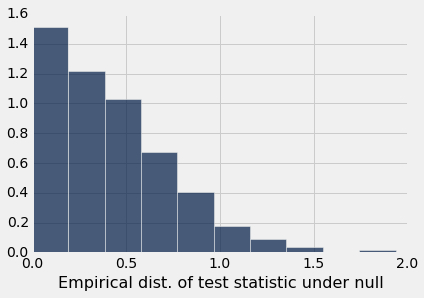

In [5]:
permutation_stat(couples, 'high_rating', 'age', abs_diff_in_means)

To explore this observation further, we will run the permutation test again, this time using the difference between the means (without the absolute value) as our test statistic. To be consistent about the sign of the difference, we will compute the difference as "mean age of Group 1 - mean age of Group 2," where Group 1 comprises the people who give the highest rating and Group 2 the people who don't. The observed value of this new test statistic is still about 1.07 (the sign is positive), because Group 1 in the sample is on average older than Group 2.

The empirical distribution of the new test statistic looks like a bell. The surface of the bell is a bit rough, and the bell has a few dents here and there, but it is recognizably a bell.

Observed value of test statistic: 1.07431900488
Empirical P value: 0.02


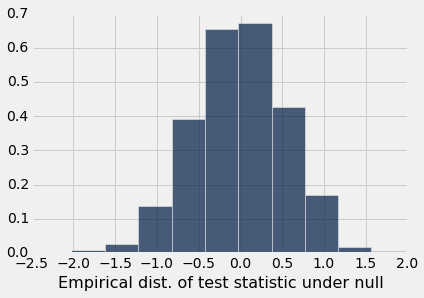

In [6]:
permutation_stat(couples, 'high_rating', 'age', diff_in_means)

The bell curve, formally known as the *normal curve*, is one of the fundamental distributions of probability theory and statistics. It arises principally in connection with probability distributions of the means of large random samples. We will discuss this more fully in later sections.

For now, observe that because the empirical distribution of the difference in means is roughly symmetric, the proportion to the right of 1.07 is about the same as the proportion to the left of -1.07. Therefore, multiplying the P-value by 2 gives an answer that is very close to the P-value of the previous test – the one that used the absolute difference in means as its test statistic. Indeed, if you fold the bell about the vertical axis and stack each bar above its reflection, you will get a histogram that looks very much like the tall "half bell" of the previous test.

**One-tailed and two-tailed tests.**

In classical statistics, tests of hypotheses using sample means typically involve calculating P-values using the bell shaped curve rather than the "folded over" version. If you read a classical analysis, you might see the term "one-tailed test" used to describe the situation in which the P-value is computed as the proportion in one tail of the bell. A "two-tailed test" uses the total proportion in two equal tails, and is thus equivalent to the test we conducted using the folded-over bell.

But as you have seen, in practical terms the tests are essentially equivalent. If you know the P-value of one, you can calculate the P-value of the other. Just be aware that sometimes, as in our examples above, the one-tailed test might give a statistically significant result while the two-tailed test does not. Such results are not contradictory – they merely point out a difficulty in rigid adherence to a fixed cutoff determining "small" values of P.

The Probability Distribution of a Sample Mean
------------------------------------------

Means of large random samples have a wonderful property that is at the heart of much statistical inference: their probability distributions are roughly bell shaped. This property allows us to determine how variable a random sample mean could be, *based on just one sample*, without any simulation at all. 

To see why this is important, consider the basis on which we have been conducting our simulations of repeated sampling.

For repeated sampling to be feasible, we need to know what to resample from. The null hypothesis specifies the chance model. In the jury panel examples, the populations of eligible jurors were known, and the null hypothesis said that the panels were drawn at random. So we simulated random sampling from the known distributions of eligible jurors. In the case of marital status and employment status, the null hypothesis allowed us to compare married and unmarried people by randomizing them into the different employment categories.

But what if the situation does not allow either of these two options? For example, suppose we have just one random sample of California households this year, and are trying to see whether the average annual household income in California exceeds $61,000, which was roughly the average annual income in California last year. How can we replicate the sampling procedure? The underlying distribution of the population is unknown (indeed, its mean is what we're trying to get at), and there is no other sample to which we can compare ours.

One way to solve this problem is to avoid replication entirely, and use other methods to approximate the probability distribution of the test statistic. If the test statistic is a sample mean, the theory of probability and statistics tells us that its probability distribution will be roughly bell shaped if the sample is large, no matter what the distribution of the underlying population looks like. This powerful result not only allows us to make inferences when replication is not straightforward, it also illuminates some important general properties of large random samples.


This chapter will help us understand all of this better. We will start by examining some fundamental properties of means.

###Properties of the mean

**Definition**: The *average* or *mean* of a list of numbers is the sum of all the numbers in the list, divided by the number of entries in the list.

In this course, we will use the words "average" and "mean" interchangeably.

**Computation**: We have computed means in two different ways. One is the Table method ``mean()``, and the other is the ``numPy`` function ``np.mean``. Here we use these two ways to calculate the average age of the people in our random sample of couples.  

In [7]:
# From a table

couples.select('age').mean()

age
43.1654


In [8]:
# From an array

np.mean(couples['age'])

43.165377176015475

We can, of course, just compute the mean by directly applying its definition. Let's do this for a list ``x_list`` consisting of 15 elements.

In [9]:
# The data: a list of numbers

x_list = [4, 4, 4, 5, 5, 5, 2, 2, 2, 2, 3, 3, 3, 3, 3 ]

# The average, computed from the list

sum(x_list)/len(x_list)

3.3333333333333335

The calculation shows that the average of ``x_list`` is $3 \frac{1}{3}$. But it also makes us wonder whether the calculation can be simplified by using the fact that there are only four distinct values in the list: 4, 5, 2, and 3. When we add up all the entries to get the numerator of the average, we can collect all the terms correpsonding to each distinct value, and save ourselves some addition:

In [10]:
(4*3 + 5*3 + 2*4 + 3*5)/15

3.3333333333333335

Distributing the division by 15 across all the terms in the numerator shows that we can calculate the average in terms of the distinct values and the proportions in which they appear:

In [11]:
4*(3/15) + 5*(3/15) + 2*(4/15) + 3*(5/15)

3.3333333333333335

###The Average and the Histogram

We have just seen that the average of a list depends only on the distinct values and their proportions. In other words, the average is a property of the distribution of distinct values in the list.

Here is ``x_list`` represented as a distribution table ``x_dist``. The average can be calculated by multiplying the ``value`` column by ``prop`` and then adding the results.

In [12]:
x_dist = Table.from_rows([[2, 4], [3, 5], [4, 3], [5, 3]], ['value', 'count'])
x_dist['prop'] = x_dist['count']/sum(x_dist['count'])

# the distribution table
x_dist

value,count,prop
2,4,0.266667
3,5,0.333333
4,3,0.2
5,3,0.2


In [13]:
sum(x_dist['value']*x_dist['prop'])

3.333333333333333

**Another way to think about the mean**. The mean of a list is the *weighted* average of the *distinct* values, where the *weights are the proportions* in which those values appear.

Physically, this implies that **the average is the balance point of the histogram**. Here is the histogram of the distribution. Imagine that it is made out of cardboard and that you are trying to balance the cardboard figure at a point on the horizontal axis. The average of $3 \frac{1}{3}$ is where the figure will balance. 

To understand why that is, you will have to study some physics. Balance points, or centers of gravity, can be calculated in exactly the way we calculated the mean from the distribution table.

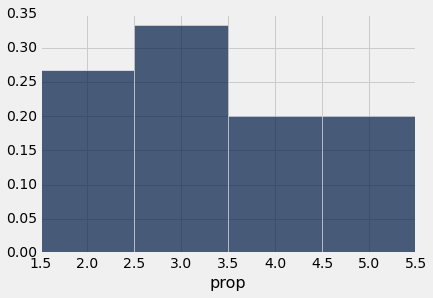

In [14]:
x_dist.select(['value', 'prop']).hist(counts='value', bins=np.arange(1.5, 5.6, 1), normed=True)

###Summary of Basic Properties of the Mean
These properties follow from the calculation; we have observed most of them in our examples above.

- The mean has the same units as the list. 
- The mean is somewhere in between the smallest and largest value on the list. 
- The mean depends only on the distribution (distinct values and proportions), not on the number of entries in the list.
- The mean is the balance point of the histogram.

###The Average and the Median

Now that we know that the mean is the balance point of the histogram, it is interesting to look at how it is related to the median, which is the "half-way point" of the sorted data. 

In terms of the histogram, we would like to compare the balance point to the point that has 50% of the area of the histogram on either side of it.

The relationship is easy to see in a simple example. Here is the list 1, 2, 2, 3, represented as a distribution table ``sym`` for "symmetric".

In [15]:
sym = Table([[1,2,3],[0.25,0.5,0.25]], ['x', 'dist'])
sym

x,dist
1,0.25
2,0.5
3,0.25


The histogram (or a calculation) shows that the average and median are both 2.

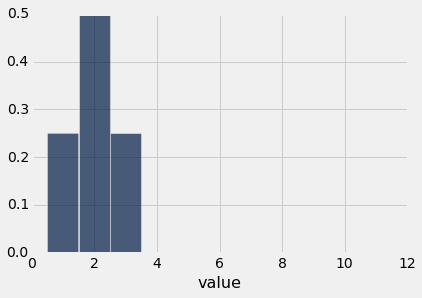

In [16]:
sym.hist(counts='x', bins=np.arange(0.5, 10.6, 1), normed=True,)
pl.xlabel("value")

In general, for **symmetric distributions**, the mean and the median are equal.

What if the distribution is not symmetric? We will explore this by making a change in the histogram above: we will take the bar at the value 3 and slide it over to the value 10.

In [17]:
# Average versus median:
# Balance point versus 50% point

slide = Table([[1,2,3,10], [0.25, 0.5, 0.25, 0], [0.25, 0.5, 0, 0.25]], 
               ['x', 'dist1', 'dist2'])
slide

x,dist1,dist2
1,0.25,0.25
2,0.5,0.5
3,0.25,0
10,0,0.25


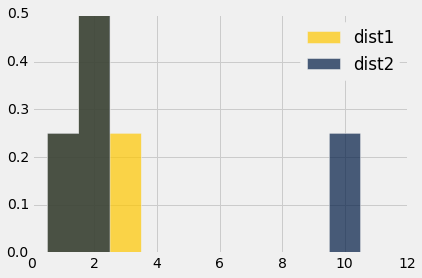

In [18]:
slide.hist(counts='x', overlay=True, bins=np.arange(0.5, 10.6, 1), normed=True)

The yellow histogram represents the original distribution; the blue histogram starts out the same as the yellow at the left end, but its rightmost bar has slid over to the value 10. 

The median and mean of the yellow distribution are both equal to 2. The median of the blue distribution is also equal to 2; the area on either side of 2 is still 50%, though the right half is distributed differently from the left. 

But the mean of the blue distribution is not 2: the blue histogram would not balance at 2. The balance point has shifted to the right:

In [19]:
sum(slide['x']*slide['dist2'])

3.75

In general, if the **histogram has a tail on one side** (the formal term is "skewed"), then the mean is pulled away from the median in the direction of the tail.

We have seen an example of a distribution with a right-hand tail: the box office gross receipts (in millions of dollars) of the highest grossing movies over the past couple of decades:

In [20]:
imdb = Table.read_table('imdb.csv')

In [21]:
box_office = imdb.select('in_millions').relabel('in_millions', 'mill$')

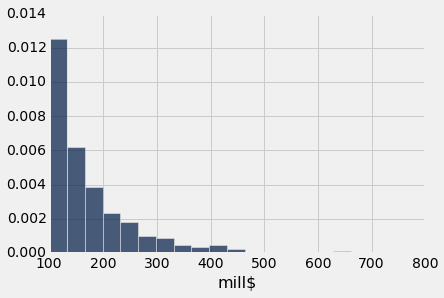

In [22]:
box_office.hist(bins=20, normed=True)

The mean gets pulled away from the median in the direction of the tail. So we expect the mean to be larger than the median, and that is indeed the case:

In [23]:
np.median(box_office['mill$'])

143.61838400000002

In [24]:
np.mean(box_office['mill$'])

174.29050139234451

**Another example.** Distributions of incomes often have right hand tails. For example, most households in the United States have low to moderate annual incomes, and a small number have extremely large annual incomes by comparison. In other words, the distribution of annual household incomes in the United States has a long right hand tail. So the mean income is greater than the median; the mean is affected by the small number of very large incomes, whereas the median is not. That is why the median is used more frequently than the mean in summaries of income distributions.

###The Rough Size of Deviations from Average

As we have seen, inferences based on test statistics depend on how those statistics vary across samples. It is therefore important to be able to quantify the variability in any list of numbers. One way is to create a measure of the difference between the values on a list and the average of the list.

We will start by defining such a measure in the context of a simple list of just four numbers.

In [25]:
toy = Table([[1, 2, 2, 10]], ['values'])
toy

values
1
2
2
10


The goal is to get a measure of roughly how far off the numbers in the list are from the average. To do this, we need the average, and all the deviations from the average. A "deviation from average" is just a value minus the average.

In [26]:
# Step 1. The average.

np.mean(toy['values'])

3.75

In [27]:
# Step 2. The deviations from average.

toy['dev_from_ave'] = toy['values'] - np.mean(toy['values'])
toy

values,dev_from_ave
1,-2.75
2,-1.75
2,-1.75
10,6.25


Some of the deviations are negative; those correspond to values that are below average. Positive deviations correspond to above-average values.

To calculate roughly how big the deviations are, it is natural to compute the mean of the deviations. But something interesting happens when all the deviations are added together:

In [28]:
sum(toy['dev_from_ave'])

0.0

The positive deviations exactly cancel out the negative ones. This is true of all lists of numbers: the sum of the deviations from average is zero. We saw this kind of property earlier, when we were defining total variation distance. 

Since the sum of the deviations is 0, the mean of the deviations will be 0 as well:

In [29]:
np.mean(toy['dev_from_ave'])

0.0

So the mean of the deviations is not a useful measure of the size of the deviations. What we want to know is roughly how big the deviations are, regardless of whether they are positive or negative. So we eliminate the signs by squaring all the deviations; then we take the mean of the squares:

In [30]:
# Step 3. The squared deviations from average

toy['sq_dev_from_ave'] = toy['dev_from_ave']**2
toy

values,dev_from_ave,sq_dev_from_ave
1,-2.75,7.5625
2,-1.75,3.0625
2,-1.75,3.0625
10,6.25,39.0625


In [31]:
# Variance = the mean squared deviation from average

var = np.mean(toy['sq_dev_from_ave'])
var

13.1875

The mean squared deviation is called the *variance* of the list. While it does give us an idea of spread, it is not on the same scale as the original variable and its units are the square of the original. This makes interpretation very difficult. So we return to the original scale by taking the positive square root of the variance:

In [32]:
# Standard Deviation:    root mean squared deviation from average
# Steps of calculation:   5    4      3       2             1

sd = var**0.5
sd

3.6314597615834874

###Standard Deviation

The quantity that we have just computed is called the *standard deviation* of the list, and is abbreviated as SD. It measures roughly how far the numbers on the list are from their average.

**Definition.** The SD of a list is defined as the *root mean square of deviations from average*. That's a mouthful. But read it from right to left and you have the sequence of steps in the calculation.

**Computation.** The ``numPy`` function ``np.std`` computes the SD of values in an array:

In [33]:
np.std(toy['values'])

3.6314597615834874

### Why use the SD instead of some other measure of spread? Answer #1.

There are a few primary reasons the SD is used more than any other measure of spread. Here is one of them.

If you know the average of a list, typically you can't infer much else about the spread in the list. You can't even infer that half the list is above average, because, as we have seen, the average and the median are typically different from each other.

If you know both the average and the SD, however, you can learn a great deal about the values in the list.

**Informal statement.** 

For all lists, the bulk of the entries are within the range "average $\pm$ a few SDs".

Try to resist the desire to know exactly what fuzzy words like "bulk" and "few" mean. We wil make them precise later in this section. For now, let us examine the statement in the context of the example of box office receipts.

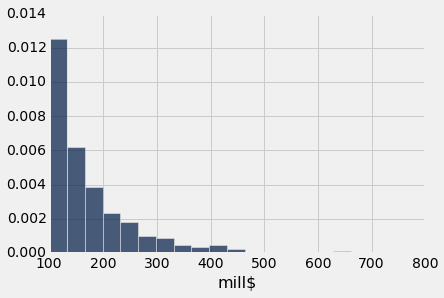

In [34]:
box_office.hist(bins=20, normed=True)

In [35]:
m = np.mean(box_office['mill$'])
m

174.29050139234451

In [36]:
s = np.std(box_office['mill$'])
s

86.152264241676363

The mean is \$174.29, and the SD is \$86.15. Notice that none of the entries on the list are below the amount "mean - SD". Indeed, none are below \$100 million. The large spread is due to the large positive deviations in the right hand tail.

In the analysis of distributions, specially those that have been represented in a histogram, it is often useful to think of the average as the origin, and distances in units of SDs. For example, here is the interval "mean $\pm$ one SD"; about 87.5% of the movies have box office receipts in this range.

In [37]:
m-s

88.138237150668147

In [38]:
m+s

260.44276563402087

In [39]:
np.count_nonzero((m-s < box_office['mill$']) & (box_office['mill$'] < m+s) )/box_office.num_rows

0.8755980861244019

The table below contains intervals of the form "mean $\pm$ a few SD", and the proportions of entries in that range. The column ``z`` quantifies the expression "a few". As you can see, once ``z`` is about 4 or so, the interval "average $\pm z$ SD" contains almost all of the data. 

This kind of behavior is true of all lists, not just the ones in our examples.

In [40]:
box_props = Table([np.arange(0.5, 6.1, 0.5)], ['z'])
box_props['m - z*s'] = m - box_props['z']*s
box_props['m + z*s'] = m + box_props['z']*s

def count_intvl(z):
    return np.count_nonzero( (m-z*s < box_office['mill$']) & (box_office['mill$'] < m+z*s) )/box_office.num_rows

box_props['proportion'] = box_props.apply(count_intvl, 'z')
box_props

z,m - z*s,m + z*s,proportion
0.5,131.214,217.367,0.395534
1,88.1382,260.443,0.875598
1.5,45.0621,303.519,0.917065
2,1.98597,346.595,0.948963
2.5,-41.0902,389.671,0.966507
3,-84.1663,432.747,0.982456
3.5,-127.242,475.823,0.992026
4,-170.319,518.9,0.992026
4.5,-213.395,561.976,0.99362
5,-256.471,605.052,0.99362


Chebychev's inequality
---------------------

This is the **formal version** of our rough statement above:

For all lists, and all positive numbers *z*, the proportion of entries that are in the range
"average $\pm z$ SDs" 
is **at least** $1 - \frac{1}{z^2}$.
          

What makes this result powerful is that it is true for all lists – all distributions, no matter how irregular, known or unknown. Specifically, Chebychev's inequality says that for every list:

- the proportion in the range "average $\pm$ 2 SDs" is at least 1 - 1/4 = 0.75

- the proportion in the range "average $\pm$ 3 SDs" is at least 1 - 1/9 $\approx$ 0.89

- the proportion in the range "average $\pm$ 4.5 SDs" is at least 1 - 1/$4.5^2$ $\approx$ 0.95

Chebychev's Inequality gives a lower bound, not an exact answer or an approximation. The proportion of entries in the range "average $\pm z$ SDs" might be quite a bit larger than $1 - 1/z^2$. But it cannot be smaller.

**Interpreting $z$**

$z$ is the number of SDs above average, and is said to be on the *standard units* scale.

Some values of standard units are negative, corresponding to original values that are below average. Other values of standard units are positive. But no matter what the distribution of the list looks like, Chebychev's Inequality says that standard units will typically be in the (-5, 5) range.

Here are some examples of moving back and forth between the original scale and the standard units scale. Recall that the average box office amounts of our list of movies is $m = \$174.29$ and the SD is $s = \$86.15$.

**Examples of converting from standard units to the original units.**
The calculation is straightforward if you remember that $z$ answers the question, "How many SDs above average is the original value?"

If $z = 2.4$, then the movie made $z*s + m = 2.4*86.15 + 174.29 = 381.05$ million dollars.

If $z = -0.3$, then the movie made $z*s + m = (-0.3)*86.15 + 174.29 = 148.45$ million dollars.

**Examples of converting from the original units to standard units.**
First find how far above average the value is on the original scale, then compare the difference with the SD.

If the movie made 220 million dollars, then $z = (220 - 174.29)/86.15 = 0.53$.

If the movie made 120 million dollars, then $z = (120 - 174.29)/86.15 = -0.63$.

In probability and statistics, $z$ is standard notation for values on the standard units scale. Converting to standard units is also known as "finding the $z$-score".

